# Importing and setting up directory

In [1]:
%mkdir -p /content/semseg
%cd /content/semseg

/content/semseg


In [2]:
import os
if not os.path.exists("17flowers.tgz"):
    print("Downloading flower dataset")
    !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
    !tar xvzf 17flowers.tgz
if not os.path.exists("trimaps.tgz"):
    !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/17/trimaps.tgz
    !tar xvzf trimaps.tgz
if not os.path.exists("datasplits.mat"):
    !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/17/datasplits.mat

--2020-05-24 22:40:47--  https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60270631 (57M) [application/x-gzip]
Saving to: ‘17flowers.tgz’

17flowers.tgz       100%[===================>]  57.48M  10.2MB/s    in 7.4s    

2020-05-24 22:40:56 (7.73 MB/s) - ‘17flowers.tgz’ saved [60270631/60270631]

jpg/files.txt
jpg/files.txt~
jpg/image_0001.jpg
jpg/image_0002.jpg
jpg/image_0003.jpg
jpg/image_0004.jpg
jpg/image_0005.jpg
jpg/image_0006.jpg
jpg/image_0007.jpg
jpg/image_0008.jpg
jpg/image_0009.jpg
jpg/image_0010.jpg
jpg/image_0011.jpg
jpg/image_0012.jpg
jpg/image_0013.jpg
jpg/image_0014.jpg
jpg/image_0015.jpg
jpg/image_0016.jpg
jpg/image_0017.jpg
jpg/image_0018.jpg
jpg/image_0019.jpg
jpg/image_0020.jpg
jpg/image_0021.jpg
jpg/image_0022.jpg
jpg/image_0023.jpg
jpg/image_0024.

In [0]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from PIL import Image
import warnings
import os
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Building Dataset object

In [0]:
# Dataset helper function
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im/255.0 - imagenet_stats[0])/imagenet_stats[1]

def denormalize(img):
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return img*imagenet_stats[1] + imagenet_stats[0]

# Mainly imported from https://colab.research.google.com/drive/1KzGRSNQpP4BonRKj3ZwGMTGdi-e2y8z-?authuser=1#scrollTo=U_g_Rq1cA1Xi
class CUB(Dataset):
    def __init__(self, files_path, split, train=True):
      
        self.files_path = files_path
        self.split = split
        if train:
            filenames = list(self.split['trn1'][0]) + list(self.split['trn2'][0]) + list(self.split['trn3'][0])
        else:
            # We only use `val1` for validation
            filenames = self.split['val1'][0]
        
        valid_filenames = []
        for i in filenames:
            img_name = f'image_{int(i)}.jpg' 
            if os.path.exists(os.path.join(files_path, 'jpg', img_name)) and \
                os.path.exists(os.path.join(files_path, 'trimaps', img_name.replace('jpg', 'png'))):
                valid_filenames.append(img_name)

        self.valid_filenames = valid_filenames
        self.num_files = len(valid_filenames)
       
    def __len__(self):
        return self.num_files
    
    def __getitem__(self, index):
        
        filename = self.valid_filenames[index]

        # Load the image
        path = os.path.join(self.files_path, 'jpg', filename)
        x = read_image(path)  # H*W*c
        x = cv2.resize(x, (224,224))
        x = normalize(x)
        x = np.rollaxis(x, 2) # To meet torch's input specification(c*H*W) 

        # Load the segmentation mask
        path = os.path.join(self.files_path, 'trimaps', filename.replace("jpg", "png"))
        y = read_image(path)
        y = cv2.resize(y, (224,224))  # H*W*c
        
        
        return x, y

def initialize_loader(train_batch_size=64, val_batch_size=64):
    split = loadmat("datasplits.mat")
    train_dataset = CUB('./', split, train= True)
    valid_dataset = CUB('./', split, train= False)
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=4, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=val_batch_size, num_workers=4)
    return train_loader, valid_loader

# Helper Functions to Visualize Data

In [0]:
def visualize_dataset(dataloader):
    """Imshow for Tensor."""
    x, y = next(iter(dataloader))
    
    fig = plt.figure(figsize=(10, 5))
    for i in range(4):
      inp = x[i]
      inp = inp.numpy().transpose(1,2,0)
      inp = denormalize(inp)
      mask = y[i] / 255.
      
      
      ax = fig.add_subplot(2, 2, i+1, xticks=[], yticks=[])
      plt.imshow(np.concatenate([inp, mask], axis=1))
      

def plot_prediction(args, model, is_train, index_list=[0], plotpath=None, title=None):

    train_loader, valid_loader = initialize_loader()
    loader = train_loader if is_train else valid_loader

    images, masks = next(iter(loader))
    images = images.float()
    if args.gpu:
        images = images.cuda()

    with torch.no_grad():
        outputs = model(images)
        
    output_predictions = outputs.argmax(1)

    # create a color pallette, selecting a color for each class
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")
    colors = [i for color in colors for i in color]

    for index in index_list:
        
        r = Image.fromarray(output_predictions[index].byte().cpu().numpy())
        r.putpalette(colors)

        fig = plt.figure(figsize=(10, 5))
        if title: plt.title(title)

        ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
        plt.imshow(denormalize(images[index].cpu().numpy().transpose(1,2,0)))

        ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
        plt.imshow(r)

        ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
        plt.imshow(masks[index])

        if plotpath:
            plt.savefig(plotpath)
            plt.close()

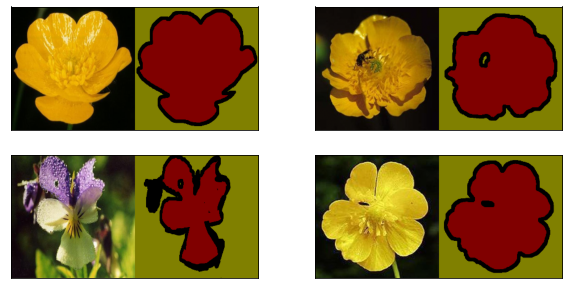

In [37]:
train_loader, valid_loader = initialize_loader()
visualize_dataset(train_loader)

# Import Pretrained model

In [0]:



model = torch.hub.load('pytorch/vision:v0.5.0', 'deeplabv3_resnet101', pretrained=True)
model._modules["classifier"][4] = nn.Conv2d(256,3,(1,1),(1,1))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [0]:
from torch.nn import Conv2d
class UNet(nn.Module):
    def __init__(self,final_out, kernel=3, num_filters=32, num_colours=3, num_in_channels=3):
        super(UNet, self).__init__()

        
        padding = kernel // 2
      
        self.layer1 = nn.Sequential(Conv2d(in_channels=num_in_channels, out_channels= num_filters, 
                              kernel_size=kernel, padding=padding),
                              nn.MaxPool2d(kernel_size=2),
                              nn.BatchNorm2d(num_filters),
                              nn.ReLU()
                              ) 
        self.layer2 =nn.Sequential(Conv2d(in_channels=num_filters, out_channels= 2*num_filters, 
                              kernel_size=kernel, padding=padding),
                              nn.MaxPool2d(kernel_size=2),
                              nn.BatchNorm2d(2*num_filters),
                              nn.ReLU()
                              ) 
        self.layer3 =nn.Sequential(Conv2d(in_channels=2*num_filters, out_channels= 2*num_filters, 
                              kernel_size=kernel, padding=padding),
                              nn.BatchNorm2d(2*num_filters),
                              nn.ReLU())

        self.layer4 =nn.Sequential(Conv2d(in_channels=2*num_filters+ 2*num_filters, out_channels= num_filters, 
                              kernel_size=kernel, padding=padding),
                              nn.Upsample(scale_factor=2),
                              nn.BatchNorm2d(num_filters),
                              nn.ReLU()
                              )  
        
        self.layer5 =nn.Sequential(Conv2d(in_channels=2*num_filters, out_channels= num_colours, 
                              kernel_size=kernel, padding=padding),
                              nn.Upsample(scale_factor=2),
                              nn.BatchNorm2d(num_colours),
                              nn.ReLU()
                              ) 
        self.conv6 = Conv2d(in_channels=num_colours + num_in_channels,
                              out_channels= final_out, 
                              kernel_size=kernel, padding=padding)


    def forward(self, x):
        
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x3 = torch.cat([x3, x2], dim=1)
        x4 = self.layer4(x3)
        x4 = torch.cat([x4, x1], dim=1)
        x5 = self.layer5(x4)
        x6 = torch.cat([x5, x], dim=1)
        x = self.conv6(x6)
        return F.softmax(x,1)

# Helper Functions for Metrics(loss and IOU)

In [0]:
def compute_loss(pred, gt):
    loss = F.cross_entropy(pred, gt)
    return loss

# from https://www.kaggle.com/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy
def iou_pytorch(outputs, labels):
    
    SMOOTH = 1e-6
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = torch.argmax(outputs, 1)
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded.mean()  # Or thresholded.mean() if you are interested in average across the batch

def convert_to_binary(masks, thres=0.5):
    binary_masks = ((masks[:, 0, :, :] ==  128) & (masks[:, 1, :, :] == 0) & (masks[:, 2, :, :] == 0)) + 0.
    return binary_masks.long()

def run_validation_step(args, epoch, model, loader, plotpath=None):

    model.eval()  # Change model to 'eval' mode (BN uses moving mean/var).

    losses = []
    ious = []
    with torch.no_grad():
        for i, (images, masks) in enumerate(loader):
            permute_masks = masks.permute(0, 3, 1, 2)  # to match the input size: B, C, H, W
            binary_masks = convert_to_binary(permute_masks)
            if args.gpu:
                images = images.cuda()
                binary_masks = binary_masks.cuda()
            output = model(images.float())
            pred_seg_masks = output

            output_predictions = pred_seg_masks[0].argmax(0)
            loss = compute_loss(pred_seg_masks, binary_masks)
            iou = iou_pytorch(pred_seg_masks, binary_masks)
            losses.append(loss.data.item())
            ious.append(iou.data.item())

        val_loss = np.mean(losses)
        val_iou = np.mean(ious)
    
    if plotpath:
        plot_prediction(args, model, False, index_list=[0], plotpath=plotpath, title='Val_%d' % epoch)
    
    return val_loss, val_iou

# Train

In [0]:
def train(args, model):
    
    
    # Numpy random seed
    np.random.seed(args.seed)
    
    # Save directory
    # Create the outputs folder if not created already
    save_dir = "outputs/" + args.experiment_name
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

   
    

    # Adam only updates learned_parameters
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learn_rate)

    train_loader, valid_loader = initialize_loader(args.train_batch_size, args.val_batch_size)
    print("Train set: {}, Test set: {}".format(
            train_loader.dataset.num_files, valid_loader.dataset.num_files))

    print("Beginning training ...")
    if args.gpu: 
        model.cuda()

    start = time.time()
    trn_losses = []
    val_losses = []
    val_ious = []
    best_iou = 0

    for epoch in range(args.epochs):

        # Train the Model
        model.train() # Change model to 'train' mode
        start_tr = time.time()
        
        
        losses = []
        for i, (images, masks) in enumerate(train_loader):
            permute_masks = masks.permute(0, 3, 1, 2)       # to match the input size: B, C, H, W
            binary_masks = convert_to_binary(permute_masks) # B, H, W
            if args.gpu:
                images = images.cuda()
                binary_masks = binary_masks.cuda()

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            output = model(images.float())
            pred_seg_masks = output

            _, pred_labels = torch.max(pred_seg_masks, 1, keepdim=True)
            loss = compute_loss(pred_seg_masks, binary_masks)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        # plot training images
        if args.plot:
            plot_prediction(args, model, True, index_list=[0], plotpath=save_dir+'/train_%d.png' % epoch, title='Train_%d' % epoch)

        # plot training images
        trn_loss = np.mean(losses)
        trn_losses.append(trn_loss)
        time_elapsed = time.time() - start_tr
        print('Epoch [%d/%d], Loss: %.4f, Time (s): %d' % (
                epoch+1, args.epochs, trn_loss, time_elapsed))

        # Evaluate the model
        start_val = time.time()
        val_loss, val_iou = run_validation_step(args, 
                                                epoch, 
                                                model,
                                                valid_loader, 
                                                save_dir+'/val_%d.png' % epoch)

        if val_iou > best_iou:
            best_iou = val_iou
            torch.save(model.state_dict(), os.path.join(save_dir, args.checkpoint_name + '-best.ckpt'))

        time_elapsed = time.time() - start_val
        print('Epoch [%d/%d], Loss: %.4f, mIOU: %.4f, Validation time (s): %d' % (
                epoch+1, args.epochs, val_loss, val_iou, time_elapsed))
        
        val_losses.append(val_loss)
        val_ious.append(val_iou)
    

    # Plot training curve
    plt.figure()
    plt.plot(trn_losses, "ro-", label="Train")
    plt.plot(val_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir+"/training_curve.png")

    # Plot validation iou curve
    plt.figure()
    plt.plot(val_ious, "ro-", label="mIOU")
    plt.legend()
    plt.title("mIOU")
    plt.xlabel("Epochs")
    plt.savefig(save_dir+"/val_iou_curve.png")

    print('Saving model...')
    torch.save(model.state_dict(), os.path.join(save_dir, args.checkpoint_name + '-{}-last.ckpt'.format(args.epochs)))

    print('Best model achieves mIOU: %.4f' % best_iou)

375150
Train set: 284, Test set: 51
Beginning training ...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1/100], Loss: 0.8679, Time (s): 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1/100], Loss: 0.7289, mIOU: 0.3490, Validation time (s): 2


Exception ignored in: Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
<bound method _ConnectionBase.__del__ of <multiprocessing.connection.Connection object at 0x7f9b36ba7518>>
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 132, in __del__
Traceback (most recent call last):
      File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/

Epoch [2/100], Loss: 0.6967, Time (s): 9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [2/100], Loss: 0.7162, mIOU: 0.3686, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [3/100], Loss: 0.6903, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [3/100], Loss: 0.7065, mIOU: 0.3824, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [4/100], Loss: 0.6788, Time (s): 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [4/100], Loss: 0.6926, mIOU: 0.4176, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [5/100], Loss: 0.6772, Time (s): 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [5/100], Loss: 0.6787, mIOU: 0.4667, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [6/100], Loss: 0.6734, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [6/100], Loss: 0.6710, mIOU: 0.4902, Validation time (s): 5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [7/100], Loss: 0.6702, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [7/100], Loss: 0.6655, mIOU: 0.5059, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [8/100], Loss: 0.6657, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [8/100], Loss: 0.6614, mIOU: 0.5176, Validation time (s): 2
Epoch [9/100], Loss: 0.6614, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [9/100], Loss: 0.6534, mIOU: 0.5471, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [10/100], Loss: 0.6695, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [10/100], Loss: 0.6697, mIOU: 0.5098, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [11/100], Loss: 0.6698, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [11/100], Loss: 0.6693, mIOU: 0.5078, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [12/100], Loss: 0.6635, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [12/100], Loss: 0.6632, mIOU: 0.5118, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [13/100], Loss: 0.6664, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [13/100], Loss: 0.6585, mIOU: 0.5255, Validation time (s): 2
Epoch [14/100], Loss: 0.6631, Time (s): 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [14/100], Loss: 0.6554, mIOU: 0.5392, Validation time (s): 2
Epoch [15/100], Loss: 0.6563, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [15/100], Loss: 0.6514, mIOU: 0.5569, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [16/100], Loss: 0.6537, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [16/100], Loss: 0.6502, mIOU: 0.5490, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [17/100], Loss: 0.6436, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [17/100], Loss: 0.7387, mIOU: 0.2647, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [18/100], Loss: 0.6437, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [18/100], Loss: 0.6575, mIOU: 0.4980, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [19/100], Loss: 0.6348, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [19/100], Loss: 0.6781, mIOU: 0.3902, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [20/100], Loss: 0.6395, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [20/100], Loss: 0.6473, mIOU: 0.5118, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [21/100], Loss: 0.6306, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [21/100], Loss: 0.6348, mIOU: 0.6275, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [22/100], Loss: 0.6296, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [22/100], Loss: 0.6265, mIOU: 0.6490, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [23/100], Loss: 0.6326, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [23/100], Loss: 0.6312, mIOU: 0.6490, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [24/100], Loss: 0.6269, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [24/100], Loss: 0.6270, mIOU: 0.6608, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [25/100], Loss: 0.6294, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [25/100], Loss: 0.6287, mIOU: 0.6667, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [26/100], Loss: 0.6223, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [26/100], Loss: 0.6213, mIOU: 0.6882, Validation time (s): 2
Epoch [27/100], Loss: 0.6207, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [27/100], Loss: 0.6166, mIOU: 0.7078, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [28/100], Loss: 0.6148, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [28/100], Loss: 0.6199, mIOU: 0.6549, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [29/100], Loss: 0.6134, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [29/100], Loss: 0.6141, mIOU: 0.7235, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [30/100], Loss: 0.6050, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [30/100], Loss: 0.6030, mIOU: 0.7706, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [31/100], Loss: 0.6040, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [31/100], Loss: 0.5994, mIOU: 0.7784, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [32/100], Loss: 0.6067, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [32/100], Loss: 0.6014, mIOU: 0.7725, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [33/100], Loss: 0.6037, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [33/100], Loss: 0.5996, mIOU: 0.7922, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [34/100], Loss: 0.6022, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [34/100], Loss: 0.5969, mIOU: 0.7922, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [35/100], Loss: 0.6045, Time (s): 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [35/100], Loss: 0.6007, mIOU: 0.7765, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [36/100], Loss: 0.6073, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [36/100], Loss: 0.6093, mIOU: 0.7451, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [37/100], Loss: 0.6098, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [37/100], Loss: 0.6176, mIOU: 0.6569, Validation time (s): 2
Epoch [38/100], Loss: 0.6076, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [38/100], Loss: 0.6077, mIOU: 0.7529, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [39/100], Loss: 0.6057, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [39/100], Loss: 0.6002, mIOU: 0.7784, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [40/100], Loss: 0.6030, Time (s): 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [40/100], Loss: 0.6017, mIOU: 0.7608, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [41/100], Loss: 0.6010, Time (s): 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [41/100], Loss: 0.6098, mIOU: 0.7529, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [42/100], Loss: 0.5988, Time (s): 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [42/100], Loss: 0.5991, mIOU: 0.7882, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [43/100], Loss: 0.6023, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [43/100], Loss: 0.6006, mIOU: 0.7882, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [44/100], Loss: 0.6012, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [44/100], Loss: 0.6111, mIOU: 0.7078, Validation time (s): 2
Epoch [45/100], Loss: 0.6052, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [45/100], Loss: 0.5946, mIOU: 0.8098, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [46/100], Loss: 0.6050, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [46/100], Loss: 0.6137, mIOU: 0.6902, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [47/100], Loss: 0.6003, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [47/100], Loss: 0.5947, mIOU: 0.7980, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [48/100], Loss: 0.6004, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [48/100], Loss: 0.5969, mIOU: 0.7902, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [49/100], Loss: 0.5984, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [49/100], Loss: 0.5960, mIOU: 0.8078, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [50/100], Loss: 0.6001, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [50/100], Loss: 0.5995, mIOU: 0.7765, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [51/100], Loss: 0.5968, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [51/100], Loss: 0.5939, mIOU: 0.8157, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [52/100], Loss: 0.5956, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [52/100], Loss: 0.5958, mIOU: 0.7941, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [53/100], Loss: 0.5948, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [53/100], Loss: 0.5913, mIOU: 0.8235, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [54/100], Loss: 0.5943, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [54/100], Loss: 0.5913, mIOU: 0.8314, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [55/100], Loss: 0.5935, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [55/100], Loss: 0.5944, mIOU: 0.8157, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [56/100], Loss: 0.5942, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [56/100], Loss: 0.5937, mIOU: 0.8216, Validation time (s): 2
Epoch [57/100], Loss: 0.5957, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [57/100], Loss: 0.5884, mIOU: 0.8431, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [58/100], Loss: 0.5926, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [58/100], Loss: 0.5963, mIOU: 0.8098, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [59/100], Loss: 0.5932, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [59/100], Loss: 0.5882, mIOU: 0.8431, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [60/100], Loss: 0.5906, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [60/100], Loss: 0.5868, mIOU: 0.8510, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [61/100], Loss: 0.5930, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [61/100], Loss: 0.5874, mIOU: 0.8471, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [62/100], Loss: 0.5923, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [62/100], Loss: 0.5856, mIOU: 0.8588, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [63/100], Loss: 0.5891, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [63/100], Loss: 0.5894, mIOU: 0.8333, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [64/100], Loss: 0.5922, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [64/100], Loss: 0.6174, mIOU: 0.6627, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [65/100], Loss: 0.5950, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [65/100], Loss: 0.5900, mIOU: 0.8353, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [66/100], Loss: 0.5951, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [66/100], Loss: 0.5938, mIOU: 0.8059, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [67/100], Loss: 0.5920, Time (s): 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [67/100], Loss: 0.5921, mIOU: 0.8255, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [68/100], Loss: 0.5949, Time (s): 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [68/100], Loss: 0.5970, mIOU: 0.8020, Validation time (s): 2
Epoch [69/100], Loss: 0.5923, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [69/100], Loss: 0.5885, mIOU: 0.8412, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [70/100], Loss: 0.5912, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [70/100], Loss: 0.5893, mIOU: 0.8353, Validation time (s): 2
Epoch [71/100], Loss: 0.5939, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [71/100], Loss: 0.6080, mIOU: 0.7255, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [72/100], Loss: 0.5893, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [72/100], Loss: 0.5974, mIOU: 0.7961, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [73/100], Loss: 0.5940, Time (s): 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [73/100], Loss: 0.5855, mIOU: 0.8490, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [74/100], Loss: 0.5895, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [74/100], Loss: 0.5875, mIOU: 0.8412, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [75/100], Loss: 0.5908, Time (s): 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [75/100], Loss: 0.5885, mIOU: 0.8451, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [76/100], Loss: 0.5895, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [76/100], Loss: 0.5890, mIOU: 0.8373, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [77/100], Loss: 0.5898, Time (s): 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [77/100], Loss: 0.5913, mIOU: 0.8078, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [78/100], Loss: 0.5861, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [78/100], Loss: 0.5847, mIOU: 0.8647, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [79/100], Loss: 0.5883, Time (s): 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [79/100], Loss: 0.5830, mIOU: 0.8667, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [80/100], Loss: 0.5873, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [80/100], Loss: 0.5896, mIOU: 0.8333, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [81/100], Loss: 0.5900, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [81/100], Loss: 0.5832, mIOU: 0.8667, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [82/100], Loss: 0.5907, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [82/100], Loss: 0.5866, mIOU: 0.8510, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [83/100], Loss: 0.5870, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [83/100], Loss: 0.5818, mIOU: 0.8686, Validation time (s): 2
Epoch [84/100], Loss: 0.5874, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [84/100], Loss: 0.5932, mIOU: 0.8118, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [85/100], Loss: 0.5857, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [85/100], Loss: 0.5853, mIOU: 0.8510, Validation time (s): 2
Epoch [86/100], Loss: 0.5883, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [86/100], Loss: 0.5864, mIOU: 0.8490, Validation time (s): 2
Epoch [87/100], Loss: 0.5873, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [87/100], Loss: 0.6235, mIOU: 0.6294, Validation time (s): 2
Epoch [88/100], Loss: 0.5852, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [88/100], Loss: 0.5878, mIOU: 0.8471, Validation time (s): 2
Epoch [89/100], Loss: 0.5890, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [89/100], Loss: 0.5886, mIOU: 0.8373, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [90/100], Loss: 0.5872, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [90/100], Loss: 0.5918, mIOU: 0.8176, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [91/100], Loss: 0.5902, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [91/100], Loss: 0.6124, mIOU: 0.6843, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [92/100], Loss: 0.5876, Time (s): 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [92/100], Loss: 0.5862, mIOU: 0.8490, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [93/100], Loss: 0.5888, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [93/100], Loss: 0.5984, mIOU: 0.7725, Validation time (s): 2
Epoch [94/100], Loss: 0.5843, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [94/100], Loss: 0.5846, mIOU: 0.8529, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [95/100], Loss: 0.5881, Time (s): 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [95/100], Loss: 0.5879, mIOU: 0.8412, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [96/100], Loss: 0.5855, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [96/100], Loss: 0.5860, mIOU: 0.8569, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [97/100], Loss: 0.5846, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [97/100], Loss: 0.5846, mIOU: 0.8588, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [98/100], Loss: 0.5867, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [98/100], Loss: 0.5812, mIOU: 0.8804, Validation time (s): 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [99/100], Loss: 0.5874, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [99/100], Loss: 0.5825, mIOU: 0.8725, Validation time (s): 2
Epoch [100/100], Loss: 0.5861, Time (s): 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [100/100], Loss: 0.5885, mIOU: 0.8275, Validation time (s): 2
Saving model...
Best model achieves mIOU: 0.8804


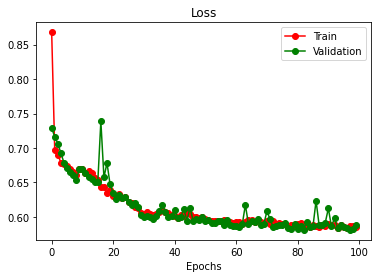

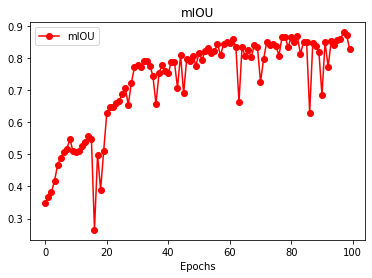

In [87]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
args = AttrDict()

my_model_dict = {
              'gpu':True, 
              'checkpoint_name':"unet-segmentation", 
              'learn_rate':0.05, 
              'train_batch_size':64, 
              'val_batch_size': 128, 
              'epochs':100 ,
              'seed':0,
              'plot':True, 
              'experiment_name': 'unet-segmentation',
}
args.update(my_model_dict)
unet_model = UNet(3, num_filters=64)
print(count_parameters(unet_model))
torch.cuda.empty_cache
torch.cuda.caching_allocator_delete
train(args, unet_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


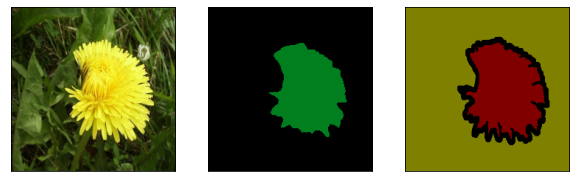

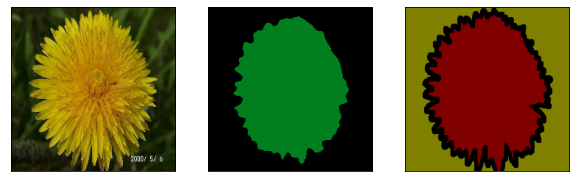

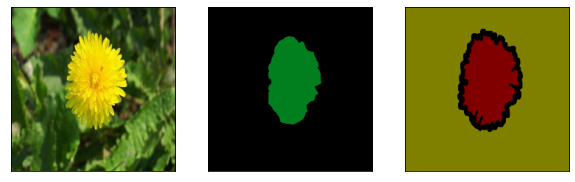

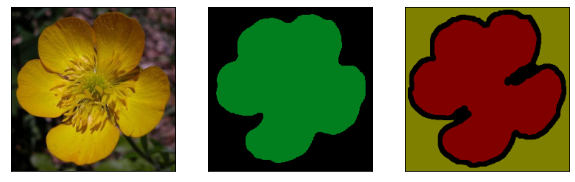

In [81]:
plot_prediction(args, unet_model, is_train=False, index_list=[0, 1, 2, 7])

In [85]:

def count_parameters(model): 
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(unet_model)

95502